In [2]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import sys

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
tf.random.set_seed(1234)
np.random.seed(1234)

# 1) Training

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Loading Dataset

In [4]:
# Downloading The Dataset
ds = tfds.load('colorectal_histology', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)

<_OptionsDataset shapes: {filename: (), image: (150, 150, 3), label: ()}, types: {filename: tf.string, image: tf.uint8, label: tf.int64}>


In [5]:
x_train,y_train= tfds.as_numpy(tfds.load('colorectal_histology', split='train[:80%]', batch_size=-1, as_supervised=True))
x_valid,y_valid= tfds.as_numpy(tfds.load('colorectal_histology', split='train[80:85%]', batch_size=-1, as_supervised=True))
x_test, y_test = tfds.as_numpy(tfds.load('colorectal_histology', split='train[85%:]', batch_size=-1, as_supervised=True))

In [5]:
from Training import create_iterators
classes      = 8
Train_bs     = 32
Inference_bs = 32
train_dataset,valid_dataset,test_dataset = create_iterators((x_train, y_train),(x_valid, y_valid),(x_test,  y_test),
                                                             Nclasses = classes, T_Bs = Train_bs, I_Bs = Inference_bs,
                                                             shape=(224,224))

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Creating Model

In [6]:
from Nets import MobileNet_body

input_layer   = tf.keras.Input((224,224,3))
output_layer  = MobileNet_body(input_layer, Quantization=False, Errors=False, N_labels = classes)
MobileNet  = tf.keras.Model(inputs=input_layer, outputs=output_layer)
#MobileNet.summary()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']
# Compile Model
MobileNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
MobileNet.summary()

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Training

In [10]:
early_stop = True
callbacks = []

# Early Stopping
# --------------
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
    callbacks.append(es_callback)


In [ ]:
MobileNet.fit(x=train_dataset,
          epochs=100,  #### set repeat in training dataset
          steps_per_epoch=int(np.ceil(x_train.shape[0] / Train_bs)),
          validation_data=valid_dataset,
          validation_steps=int(np.ceil(x_valid.shape[0] / Train_bs)), 
          callbacks=callbacks)

In [9]:
(OrigLoss, OrigAcc) = MobileNet.evaluate(test_dataset)

24/24 [==============================] - 1s 46ms/step - loss: 0.5254 - accuracy: 0.8040


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) Save/Load Weigths

In [6]:
cwd = os.getcwd()
Wgt_dir = os.path.join(cwd, 'Trained Weights')
Wgt_dir = os.path.join(Wgt_dir, 'MobileNet')
Wgt_dir = os.path.join(Wgt_dir, 'Colorectal Dataset')
Wgt_dir = os.path.join(Wgt_dir,'Weights')
#MobileNet.load_weights(Wgt_dir)

# 2) Quantization 

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Starting Point

In [6]:
from Quantization_and_Errors import Check_Accuracy_and_Loss

# Showing accuracy with a heurisitc value of cuantization with no decrease in performance
Check_Accuracy_and_Loss('Mobile', test_dataset, Wgt_dir, N_labels = 8, IShape = (224,224,3),
                         Afrac_size = 11, Aint_size = 4, Wfrac_size = 11, Wint_size = 4);

24/24 [==============================] - 3s 106ms/step - loss: 0.4932 - accuracy: 0.8307


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Activation Fractional Number of Bits

In [11]:
E1_bits      = [4,5,6,7,8,9,10,11,12,13,14,15]
E1_acc       = [None]*12
E1_loss      = [None]*12
for index in range(0,12):
    (E1_acc[index],E1_loss[index]) = Check_Accuracy_and_Loss(model = 'Mobile', test_dataset = test_dataset,
                                                             Wgt_dir = Wgt_dir, N_labels = 8, IShape = (224,224,3),
                                                             Afrac_size   = E1_bits[index], Aint_size   = 11,
                                                             Wfrac_size   =             11, Wint_size   = 11)

24/24 [==============================] - 2s 99ms/step - loss: 0.4932 - accuracy: 0.8267


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; c) Activation Integer Number of Bits

In [12]:
E2_bits      = [0,1,2,3,4,5,6]
E2_acc       = [None]*7
E2_loss      = [None]*7
for index in range(0,7):
    (E2_acc[index],E2_loss[index]) = Check_Accuracy_and_Loss(model = 'Mobile', test_dataset = test_dataset,
                                                             Wgt_dir = Wgt_dir, N_labels = 8, IShape = (224,224,3),
                                                             Afrac_size   =  11, Aint_size   = E2_bits[index],
                                                             Wfrac_size   =  11, Wint_size   =              11)

24/24 [==============================] - 2s 99ms/step - loss: 0.4932 - accuracy: 0.8307


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; d) Weights Fractional Number of Bits

In [13]:
E3_bits      = [7,8,9,10,11,12,13,14,15]
E3_acc       = [None]*9
E3_loss      = [None]*9
for index in range(0,9):
    (E3_acc[index],E3_loss[index]) = Check_Accuracy_and_Loss(model = 'Mobile', test_dataset = test_dataset,
                                                             Wgt_dir = Wgt_dir, N_labels = 8, IShape = (224,224,3),
                                                             Afrac_size   =              11, Aint_size = 11,
                                                             Wfrac_size   = E3_bits[index], Wint_size = 11)

24/24 [==============================] - 2s 99ms/step - loss: 0.5272 - accuracy: 0.8067


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Weights Integer Number of Bits

In [14]:
E4_bits      = [0,1,2,3,4,5,6]
E4_acc       = [None]*7
E4_loss      = [None]*7
for index in range(0,7):
    (E4_acc[index],E4_loss[index]) = Check_Accuracy_and_Loss(model = 'Mobile', test_dataset = test_dataset,
                                                             Wgt_dir = Wgt_dir, N_labels = 8, IShape = (224,224,3),
                                                             Afrac_size   =  11, Aint_size = 11,
                                                             Wfrac_size   = 11, Wint_size = E4_bits[index])

24/24 [==============================] - 2s 99ms/step - loss: 0.4932 - accuracy: 0.8307


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Best Config

In [15]:
Check_Accuracy_and_Loss('Mobile', test_dataset, Wgt_dir, N_labels = 8, IShape = (224,224,3),
                        Afrac_size = 11, Aint_size = 4, Wfrac_size = 11, Wint_size = 0);

24/24 [==============================] - 2s 100ms/step - loss: 0.4694 - accuracy: 0.8320


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Used Config

In [8]:
Check_Accuracy_and_Loss('Mobile', test_dataset, Wgt_dir, N_labels = 8, IShape = (224,224,3),
                        Afrac_size = 8, Aint_size = 3, Wfrac_size = 11, Wint_size = 0);

24/24 [==============================] - 2s 98ms/step - loss: 0.5168 - accuracy: 0.8027


### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; e) Plotting Results

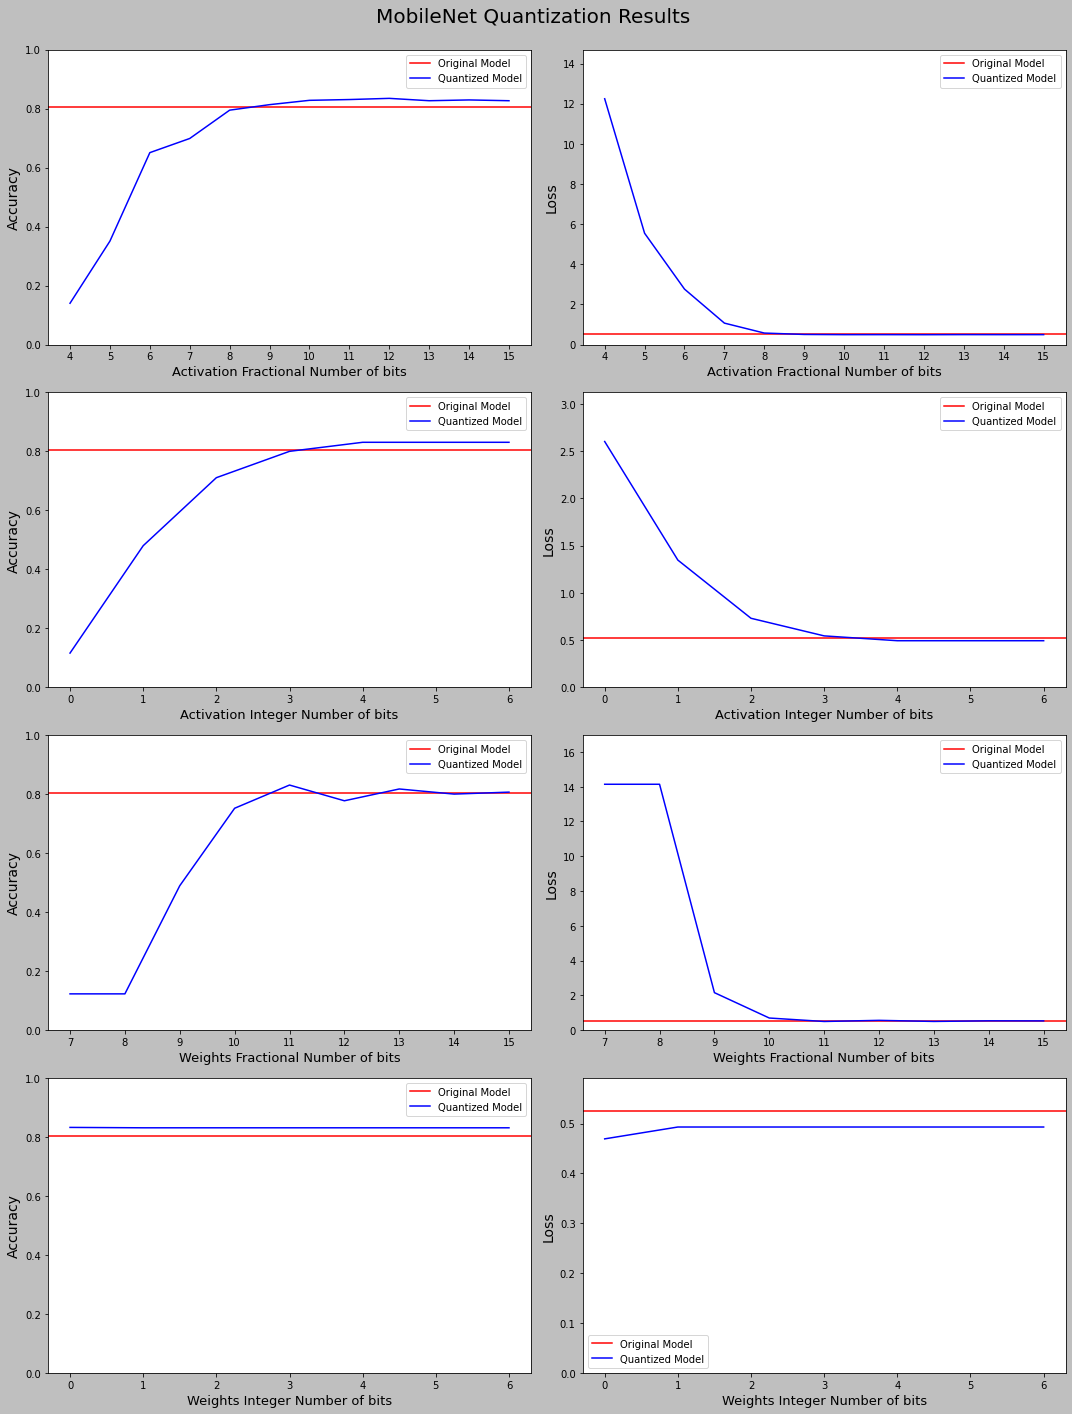

In [18]:
from Plots import Plot_4Experiments

Qbits   = [E1_bits,E2_bits,E3_bits,E4_bits]
Accs    = [E1_acc,E2_acc,E3_acc,E4_acc]
Losses  = [E1_loss,E2_loss,E3_loss,E4_loss]
xlabels = ['Activation Fractional Number of bits', 'Activation Integer Number of bits',
                       'Weights Fractional Number of bits',   'Weights Integer Number of bits' ]

Plot_4Experiments('MobileNet', Qbits, Accs, Losses, OrigAcc, OrigLoss, xlabels, figsize = (15,20), save_fig = True,
                 fig_dir = 'Figures/Quantization Experiments/MobileNet/Colorectal Dataset/Weights/')

# 3) Buffer Simulation

In [73]:
from Training import create_iterators
classes      = 8
Inference_bs = 1
_,_,test_dataset = create_iterators(None,None,(x_test,  y_test), Nclasses = classes, I_Bs = Inference_bs, shape=(224,224))
#del x_train,y_train,x_valid,y_valid

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; a) Load Quantized Model

In [77]:
from Nets import MobileNet_body
from Quantization_and_Errors import Weight_Quantization

Qinput_layer  = tf.keras.Input((224,224,3))
Qoutput_layer = MobileNet_body(Qinput_layer, Quantization = True, Errors = False, N_labels=8, word_size = 12,frac_size = 8)
QMobileNet    = tf.keras.Model(inputs=Qinput_layer, outputs=Qoutput_layer)
# Optimization params
# -------------------
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
metrics = ['accuracy']
# Compile Model
QMobileNet.compile(optimizer=optimizer, loss=loss, metrics=metrics)
QMobileNet.load_weights(Wgt_dir).expect_partial()
Weight_Quantization(model = QMobileNet, Frac_Bits = 11, Int_Bits = 0)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; b) Simulate a portion of the test dataset  through the buffers 

In [74]:
from tensorflow.python.keras import backend as K
def get_all_outputs(model, input_data, learning_phase=False):
    outputs = [layer.output for layer in model.layers] # exclude Input
    layers_fn = K.function([model.input], outputs)
    return layers_fn([input_data])

In [9]:
from Simulation import MobileNet_Sim, save_obj, load_obj
from datetime import datetime

start_from_zero = False

if start_from_zero:
    # Bufferes
    IOBuffer_size = 817216*12
    IOBuffer_1 = np.zeros(IOBuffer_size,dtype=np.int8)
    IOBuffer_2 = np.zeros(IOBuffer_size,dtype=np.int8)
    # Numero de ciclos en valor 1 por celda
    duty_1 = np.zeros(IOBuffer_size,dtype=np.uint32)
    duty_2 = np.zeros(IOBuffer_size,dtype=np.uint32)
    ciclos = 0
    start_from = 0
else:
    duty_1 = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/duty_B1')
    duty_2 = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/duty_B2')
    ciclos = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/ciclos')
    IOBuffer_1 = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/IOBuffer_1')
    IOBuffer_2 = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/IOBuffer_2')
    start_from = 199
    
iterator   = iter(test_dataset)
index      = 0
batch_size = 200
while index < batch_size:
    image = next(iterator)[0]
    if index > start_from:
        a = get_all_outputs(QMobileNet,image)
        acts = [a[2],a[9],a[15],a[21],a[28],a[34],a[40],a[46],a[53],a[59],a[65],a[71],a[78],a[84],a[90],a[96],a[102],
                a[108],a[114],a[120],a[126],a[132],a[138],a[144],a[151],a[157],a[163],a[169],a[173],
                a[179].reshape((1, 1, 1, 8))]
        del a
        if index % 2 == 0:
            ciclos += MobileNet_Sim(acts, IOBuffer_1, duty_1, IOBuffer_2, duty_2, word_size = 16, frac_size = 11)
        else:
            ciclos += MobileNet_Sim(acts, IOBuffer_2, duty_2, IOBuffer_1, duty_1, word_size = 16, frac_size = 11)
        save_obj(duty_1,'Stats/MobileNet/Colorectal Dataset/Weights/duty_B1')
        save_obj(duty_2,'Stats/MobileNet/Colorectal Dataset/Weights/duty_B2')
        save_obj(ciclos,'Stats/MobileNet/Colorectal Dataset/Weights/ciclos')
        save_obj(IOBuffer_1,'Stats/MobileNet/Colorectal Dataset/Weights/IOBuffer_1')
        save_obj(IOBuffer_2,'Stats/MobileNet/Colorectal Dataset/Weights/IOBuffer_2')
        print('imagenes procesadas:',index,' tiempo:',datetime.now().strftime("%H:%M:%S"),'ciclos: ',ciclos)
    index = index + 1

imagenes procesadas: 200  tiempo: 23:00:53 ciclos:  768675600


In [68]:
from Simulation import load_obj

duty_1 = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/duty_B1')
duty_2 = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/duty_B2')
ciclos = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/ciclos')
IOBuffer_1 = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/IOBuffer_1')
IOBuffer_2 = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/IOBuffer_2')

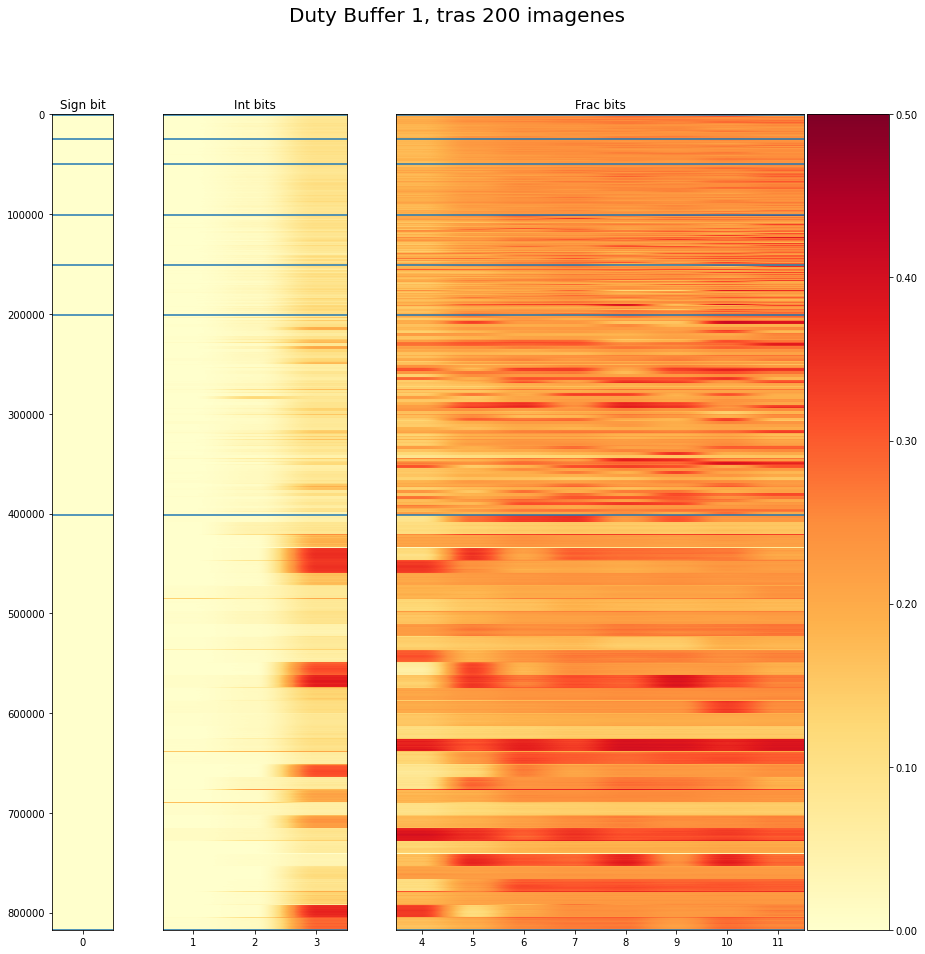

In [55]:
from Plots import plot_duty
plot_duty(duty_1, ciclos, 'Duty Buffer 1, tras 200 imagenes', low=0, high=817216, mode = 'Duty',
          figsize = (15,15), bits_dist=[1,3,8], threshold = None,
          save_fig = False, fig_dir='Figures/Buffer Heatmaps/MobileNet/Colorectal Dataset/Weights/Duty Buffer 1',
          sections_boundaries = [1024,25088,50176,100352,150528,200704,401408,817216])

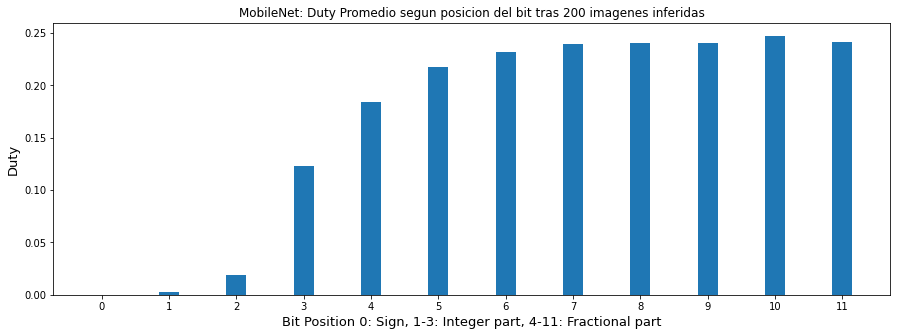

In [98]:
import matplotlib.pyplot as plt

data   = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/duty_B1').astype(np.uint64)
ciclos = load_obj('Stats/MobileNet/Colorectal Dataset/Weights/ciclos').astype(np.uint64)
data   = np.reshape(data,(817216,12))
data   = np.sum(data,axis=0)/(ciclos*817216)
data   = np.reshape(data,(1,-1))

plt.figure(figsize=(15,5))
plt.title('MobileNet: Duty Promedio segun posicion del bit tras 200 imagenes inferidas')
fig = plt.bar(['0','1','2','3','4','5','6','7','8','9','10','11'],data[0],0.3)
plt.xlabel('Bit Position 0: Sign, 1-3: Integer part, 4-11: Fractional part',fontsize=13)
plt.ylabel('Duty',fontsize=13)
plt.savefig('Figures/Buffer Heatmaps/MobileNet/Colorectal Dataset/Weights/Duty per bit position')

# 4) Error Injection

In [7]:
from Training import create_iterators

classes      = 8
Inference_bs = 1
_,_,test_dataset = create_iterators(None,None,(x_test,  y_test), Nclasses = classes, I_Bs = Inference_bs, shape=(224,224))

In [8]:
from copy import deepcopy
from Quantization_and_Errors import Check_Accuracy_and_Loss
from Simulation import save_obj, load_obj
from datetime import datetime

Start_from_zero = True

if Start_from_zero:
    tmp_dict = {0.001:[],0.01:[],0.1:[],0.2:[]}  #Portions to test in each section
    tmp_dict = {'Buffer 1': {'Addresses 0-1024': deepcopy(tmp_dict),
                             'Addresses 1024-50176': deepcopy(tmp_dict),
                             'Addresses 50176-100352': deepcopy(tmp_dict),
                             'Addresses 100352-200704': deepcopy(tmp_dict),
                             'Addresses 200704-401408': deepcopy(tmp_dict) },            
                'Buffer 2': {'Addresses 0-50176': deepcopy(tmp_dict),
                             'Addresses 50176-100352': deepcopy(tmp_dict),
                             'Addresses 100352-200704': deepcopy(tmp_dict),
                             'Addresses 200704-401408': deepcopy(tmp_dict),
                             'Addresses 408608-817216': deepcopy(tmp_dict)}}
    Accs     = {'1st bit':deepcopy(tmp_dict)}
    Loss     = {'1st bit':deepcopy(tmp_dict)}
else:
    Accs     = load_obj('Errors/MobileNet/Colorectal Dataset/Weights/Accs')
    Loss     = load_obj('Errors/MobileNet/Colorectal Dataset/Weights/Loss')


Mapping   = {'Buffer 1':[True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,
                         True,False,True,False,True,False,True,False,True,False,True,False,True],  #Buffer_Error_Mask
             'Buffer 2':[False,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,
                         False,True,False,True,False,True,False,True,False,True,False,True,False], #Buffer_Error_Mask
             'Addresses 0-1024'       : (range(0,1024)       ,1024),   #Range and Len of each section
             'Addresses 0-50176'      : (range(0,50176)      ,50176),  
             'Addresses 1024-50176'   : (range(1024,50176)   ,49152),
             'Addresses 50176-100352' : (range(50176,100352) ,50176),
             'Addresses 100352-200704': (range(100352,200704),100352),
             'Addresses 200704-401408': (range(200704,401408),200704),
             'Addresses 408608-817216': (range(408608,817216),408608),
             '1st bit': ['1xxxxxxxxxxx'], # mask of the error
             '2nd bit': ['x1xxxxxxxxxx'],
             '3rd bit': ['xx1xxxxxxxxx']}

Num_of_samples = 100
for bit_loc in Loss:
    for Buffer in Loss[bit_loc]:
        for section in Loss[bit_loc][Buffer]:
            for Enumber in Loss[bit_loc][Buffer][section]:
                for index in range(0,Num_of_samples):
                    number_of_errors = np.ceil(Enumber*Mapping[section][1]).astype(int)
                    locs = np.random.choice(Mapping[section][0],number_of_errors,False)
                    acc,loss = Check_Accuracy_and_Loss('Mobile', test_dataset, Wgt_dir, N_labels = 8, IShape = (224,224,3),
                                                        Afrac_size = 8, Aint_size = 3, Wfrac_size = 11, Wint_size = 0,
                                                        Bs=Inference_bs, verbose = 0, Layer_Error_mask = Mapping[Buffer],
                                                        locations = locs, errors = Mapping[bit_loc]*number_of_errors)
                    
                    Accs[bit_loc][Buffer][section][Enumber].append(acc)
                    Loss[bit_loc][Buffer][section][Enumber].append(loss)
                print(bit_loc+', '+Buffer+', '+section+', '+str(Enumber)+' completada: ',
                      datetime.now().strftime("%H:%M:%S"))
                save_obj(Accs,'Errors/MobileNet/Colorectal Dataset/Weights/Accs')
                save_obj(Loss,'Errors/MobileNet/Colorectal Dataset/Weights/Loss')

1st bit, Buffer 1, Addresses 0-1024, 0.001 completada:  17:14:29
1st bit, Buffer 1, Addresses 0-1024, 0.01 completada:  17:54:15
1st bit, Buffer 1, Addresses 0-1024, 0.1 completada:  18:33:55
1st bit, Buffer 1, Addresses 0-1024, 0.2 completada:  19:13:39
1st bit, Buffer 1, Addresses 1024-50176, 0.001 completada:  19:52:03
1st bit, Buffer 1, Addresses 1024-50176, 0.01 completada:  20:30:00
1st bit, Buffer 1, Addresses 1024-50176, 0.1 completada:  21:10:21
1st bit, Buffer 1, Addresses 1024-50176, 0.2 completada:  21:54:12
1st bit, Buffer 1, Addresses 50176-100352, 0.001 completada:  22:29:36
1st bit, Buffer 1, Addresses 50176-100352, 0.01 completada:  23:07:12
1st bit, Buffer 1, Addresses 50176-100352, 0.1 completada:  00:02:37
1st bit, Buffer 1, Addresses 50176-100352, 0.2 completada:  01:02:26
1st bit, Buffer 1, Addresses 100352-200704, 0.001 completada:  01:39:16
1st bit, Buffer 1, Addresses 100352-200704, 0.01 completada:  02:12:31
1st bit, Buffer 1, Addresses 100352-200704, 0.1 comp

In [29]:
Accs     = load_obj('Errors/MobileNet/Colorectal Dataset/Weights/Accs')
Loss     = load_obj('Errors/MobileNet/Colorectal Dataset/Weights/Loss')

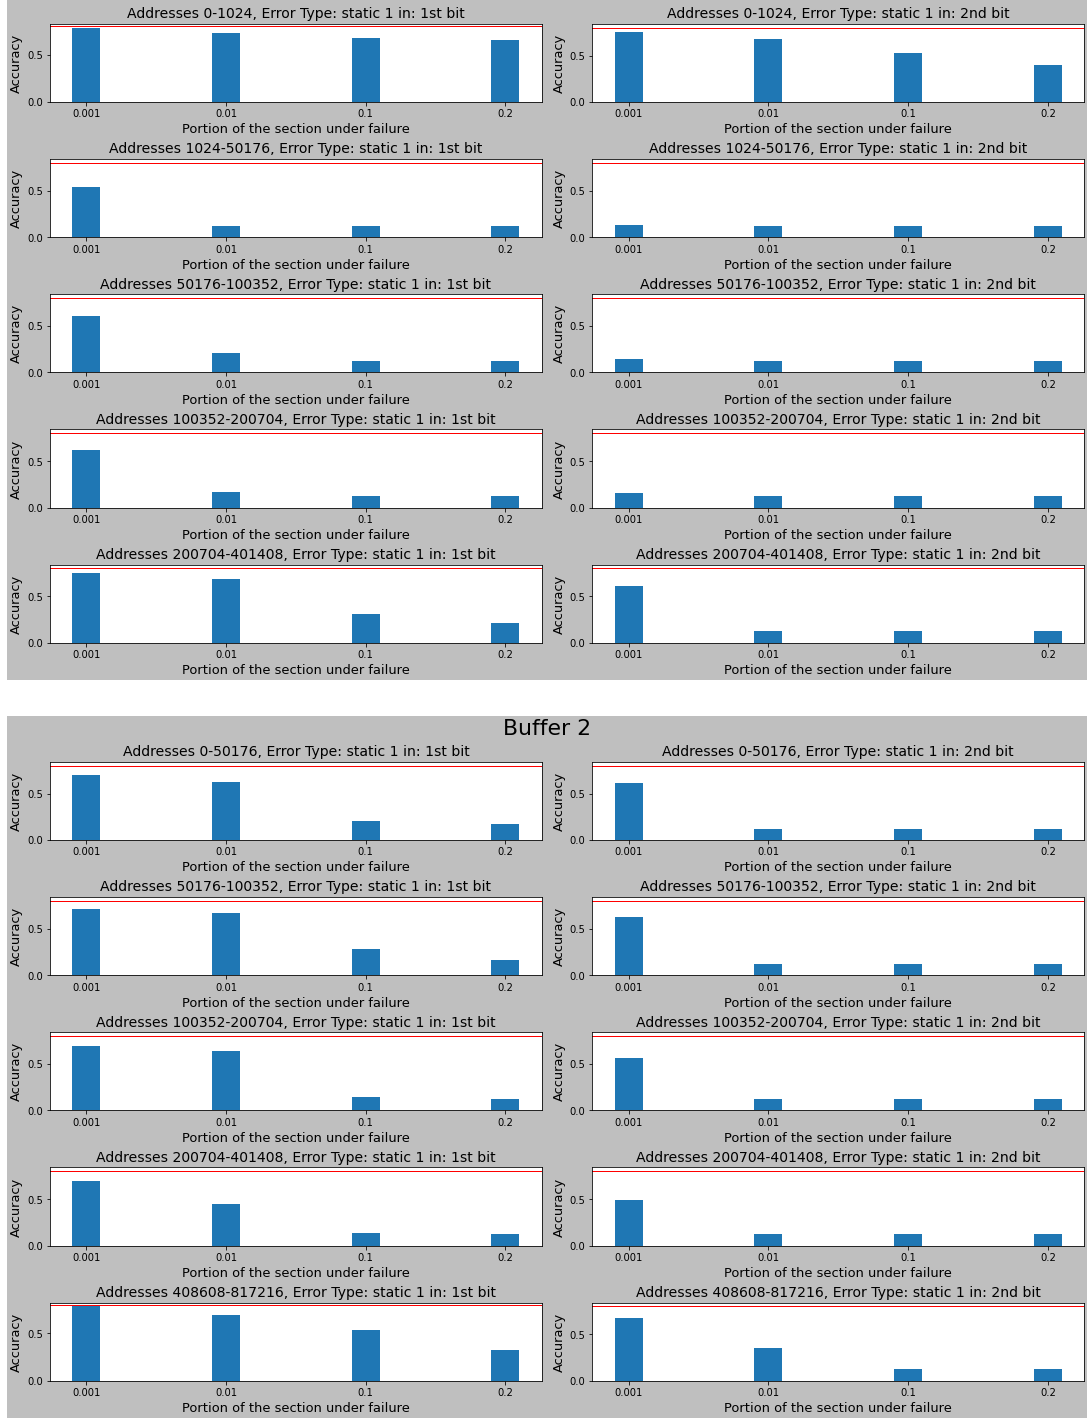

In [33]:
from Plots import Plot_Errors
from Simulation import load_obj

DataDicts = load_obj('Errors/MobileNet/Colorectal Dataset/Weights/Accs')
Sections = [['Addresses 0-1024',  'Addresses 1024-50176', 'Addresses 50176-100352', 'Addresses 100352-200704','Addresses 200704-401408'],
            ['Addresses 0-50176', 'Addresses 50176-100352', 'Addresses 100352-200704','Addresses 200704-401408','Addresses 408608-817216']]
keys1    = ['1st bit','2nd bit']
keys2    = ['Buffer 1','Buffer 2']

Plot_Errors(DataDicts, Sections, keys1, keys2, 0.8027, figsize=(15,20), save_fig=True,
            xlabel  = 'Portion of the section under failure', BoxPlot = False,  Scaled_max_value= None, ylabel = 'Accuracy',
            fig_dir = 'Figures/Errors/MobileNet/Colorectal Dataset/Weights/Accuracy')

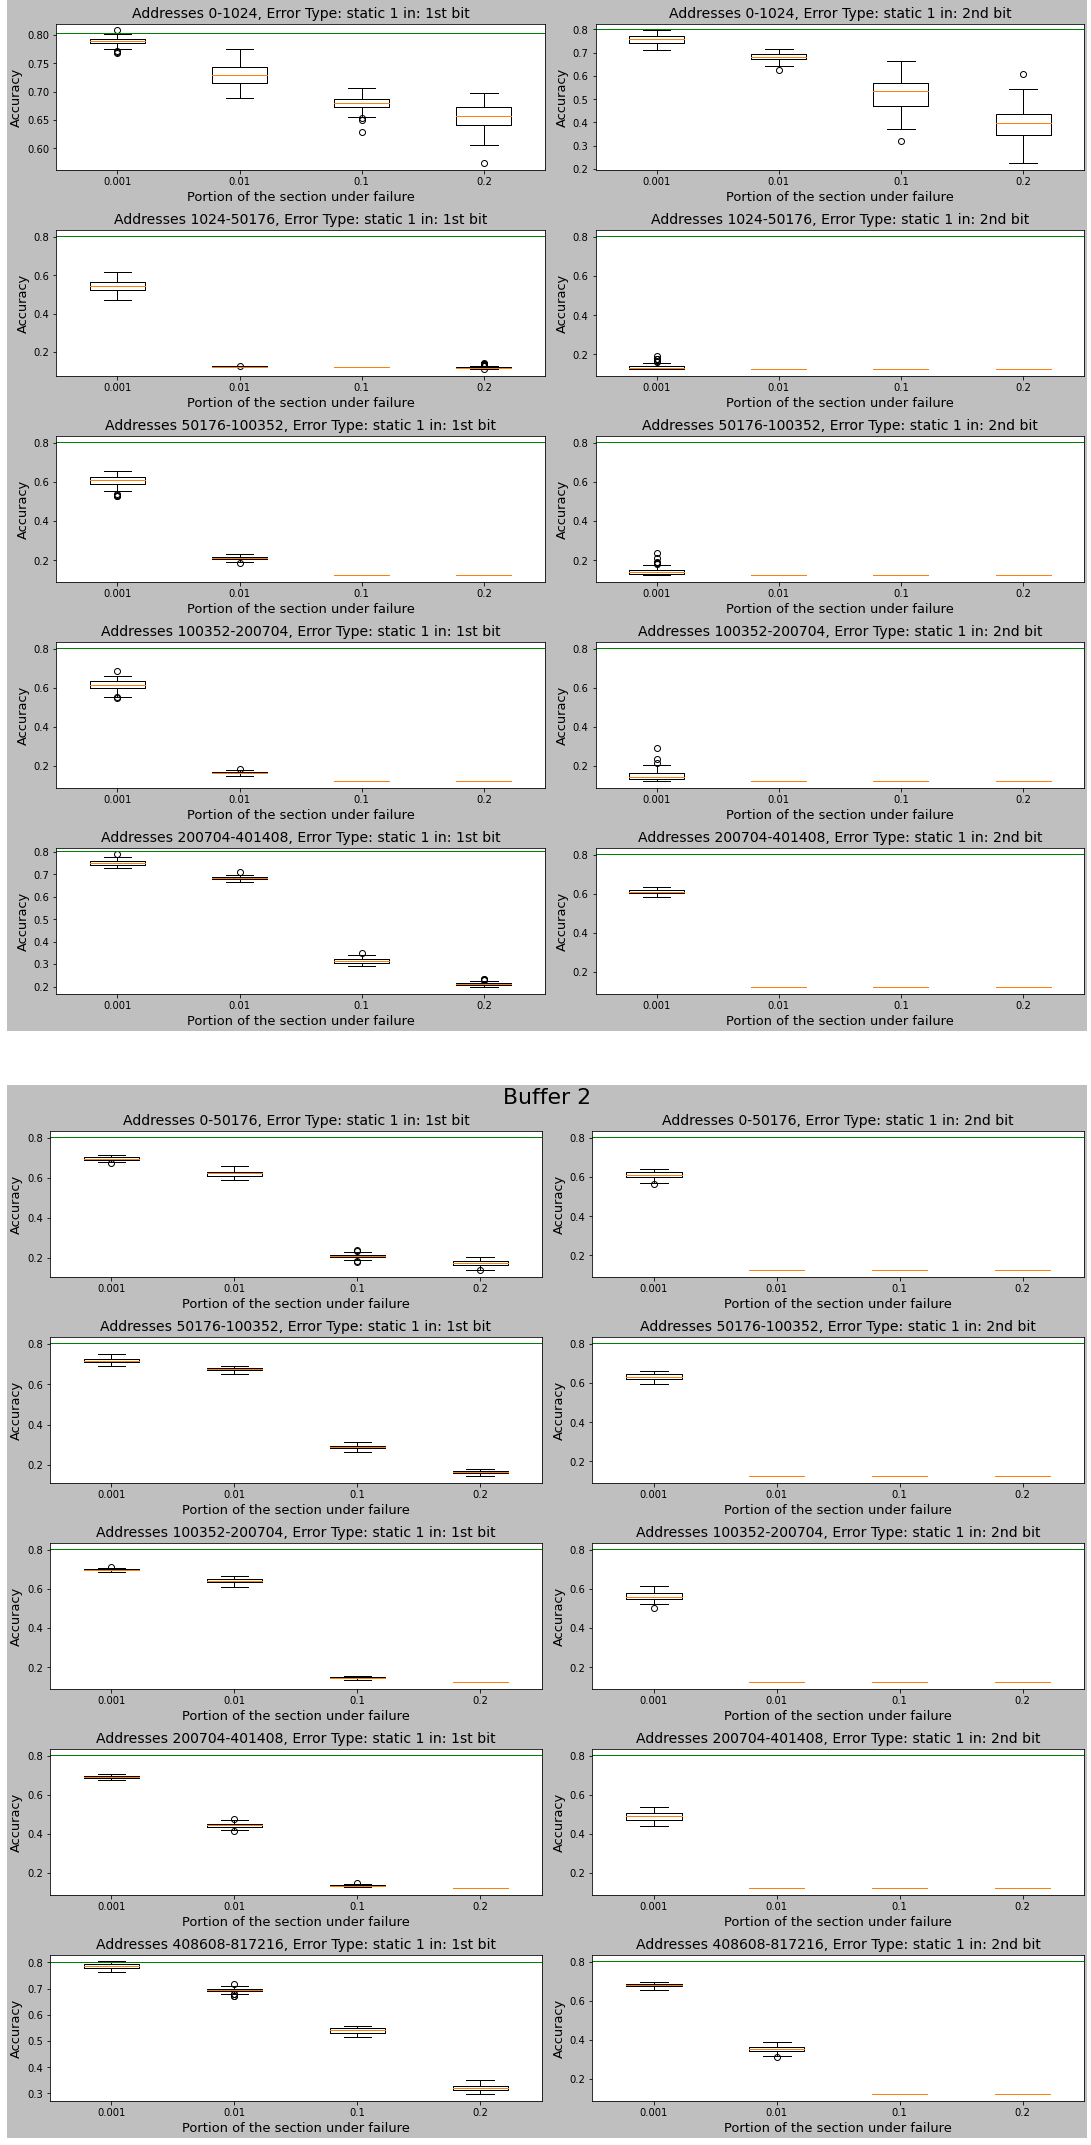

In [36]:
DataDicts = load_obj('Errors/MobileNet/Colorectal Dataset/Weights/Accs')
Sections = [['Addresses 0-1024',  'Addresses 1024-50176', 'Addresses 50176-100352', 'Addresses 100352-200704','Addresses 200704-401408'],
            ['Addresses 0-50176', 'Addresses 50176-100352', 'Addresses 100352-200704','Addresses 200704-401408','Addresses 408608-817216']]
keys1    = ['1st bit','2nd bit']
keys2    = ['Buffer 1','Buffer 2']

Plot_Errors(DataDicts, Sections, keys1, keys2, 0.8027, figsize=(15,30), save_fig=True,
            xlabel  = 'Portion of the section under failure', BoxPlot = True,  Scaled_max_value= None, ylabel = 'Accuracy',
            fig_dir = 'Figures/Errors/MobileNet/Colorectal Dataset/Weights/Accuracy BoxPlot')

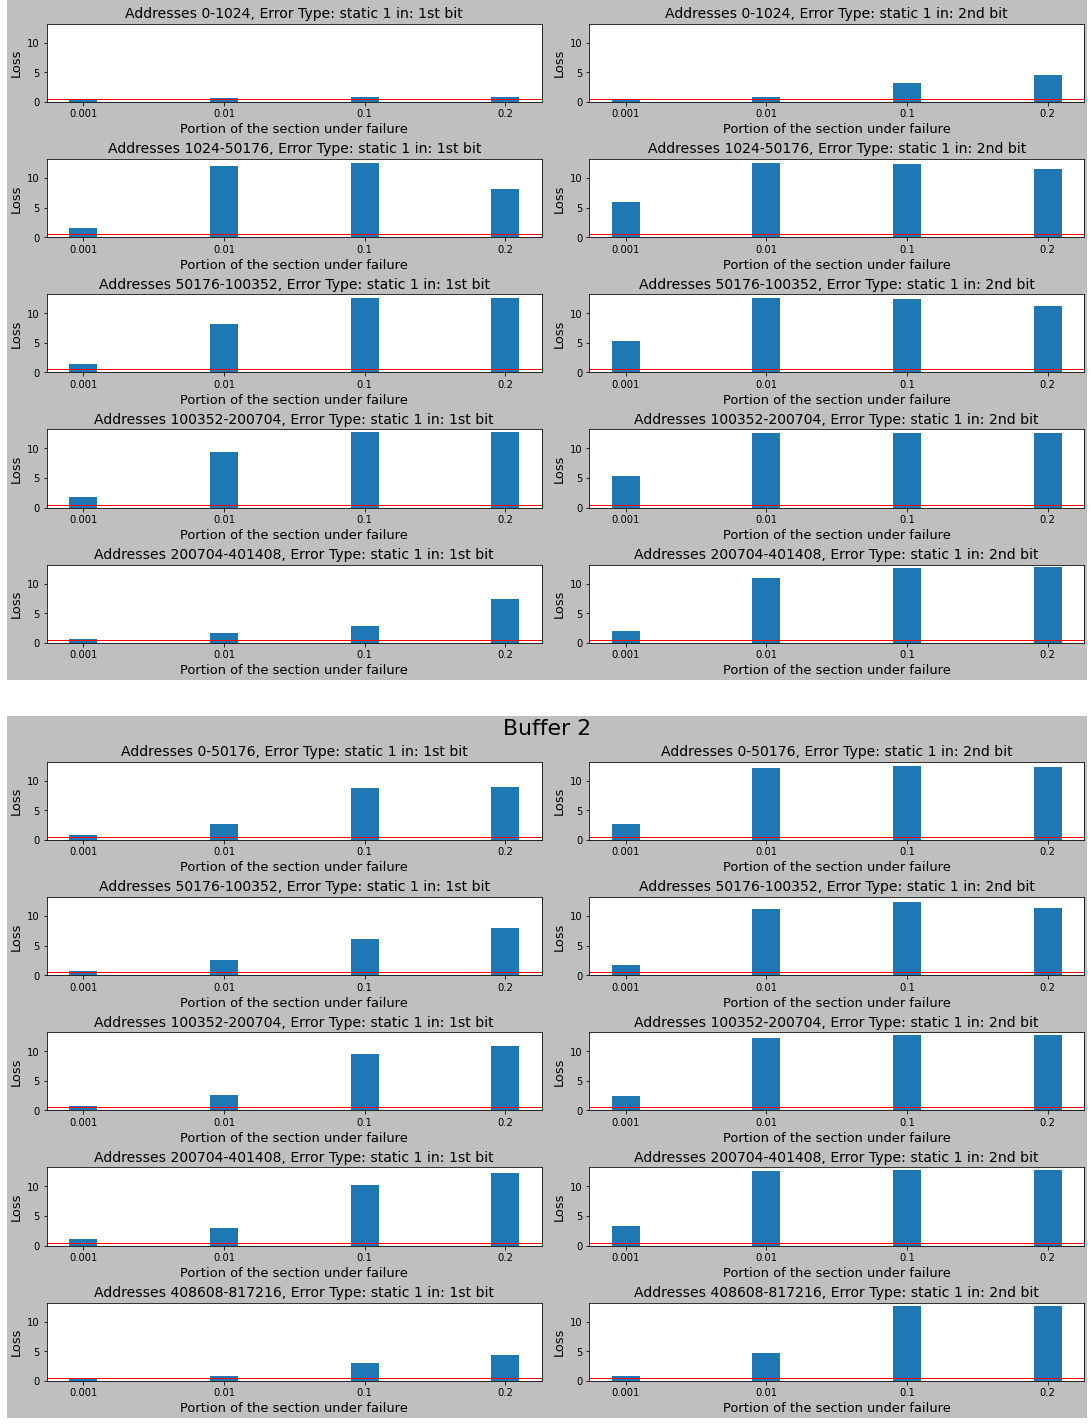

In [40]:
DataDicts = load_obj('Errors/MobileNet/Colorectal Dataset/Weights/Loss')
Sections = [['Addresses 0-1024',  'Addresses 1024-50176', 'Addresses 50176-100352', 'Addresses 100352-200704','Addresses 200704-401408'],
            ['Addresses 0-50176', 'Addresses 50176-100352', 'Addresses 100352-200704','Addresses 200704-401408','Addresses 408608-817216']]
keys1    = ['1st bit','2nd bit']
keys2    = ['Buffer 1','Buffer 2']

Plot_Errors(DataDicts, Sections, keys1, keys2, 0.5168, figsize=(15,20), save_fig=True,
            xlabel  = 'Portion of the section under failure', BoxPlot = False,  Scaled_max_value= 11, ylabel = 'Loss',
            fig_dir = 'Figures/Errors/MobileNet/Colorectal Dataset/Weights/Loss')

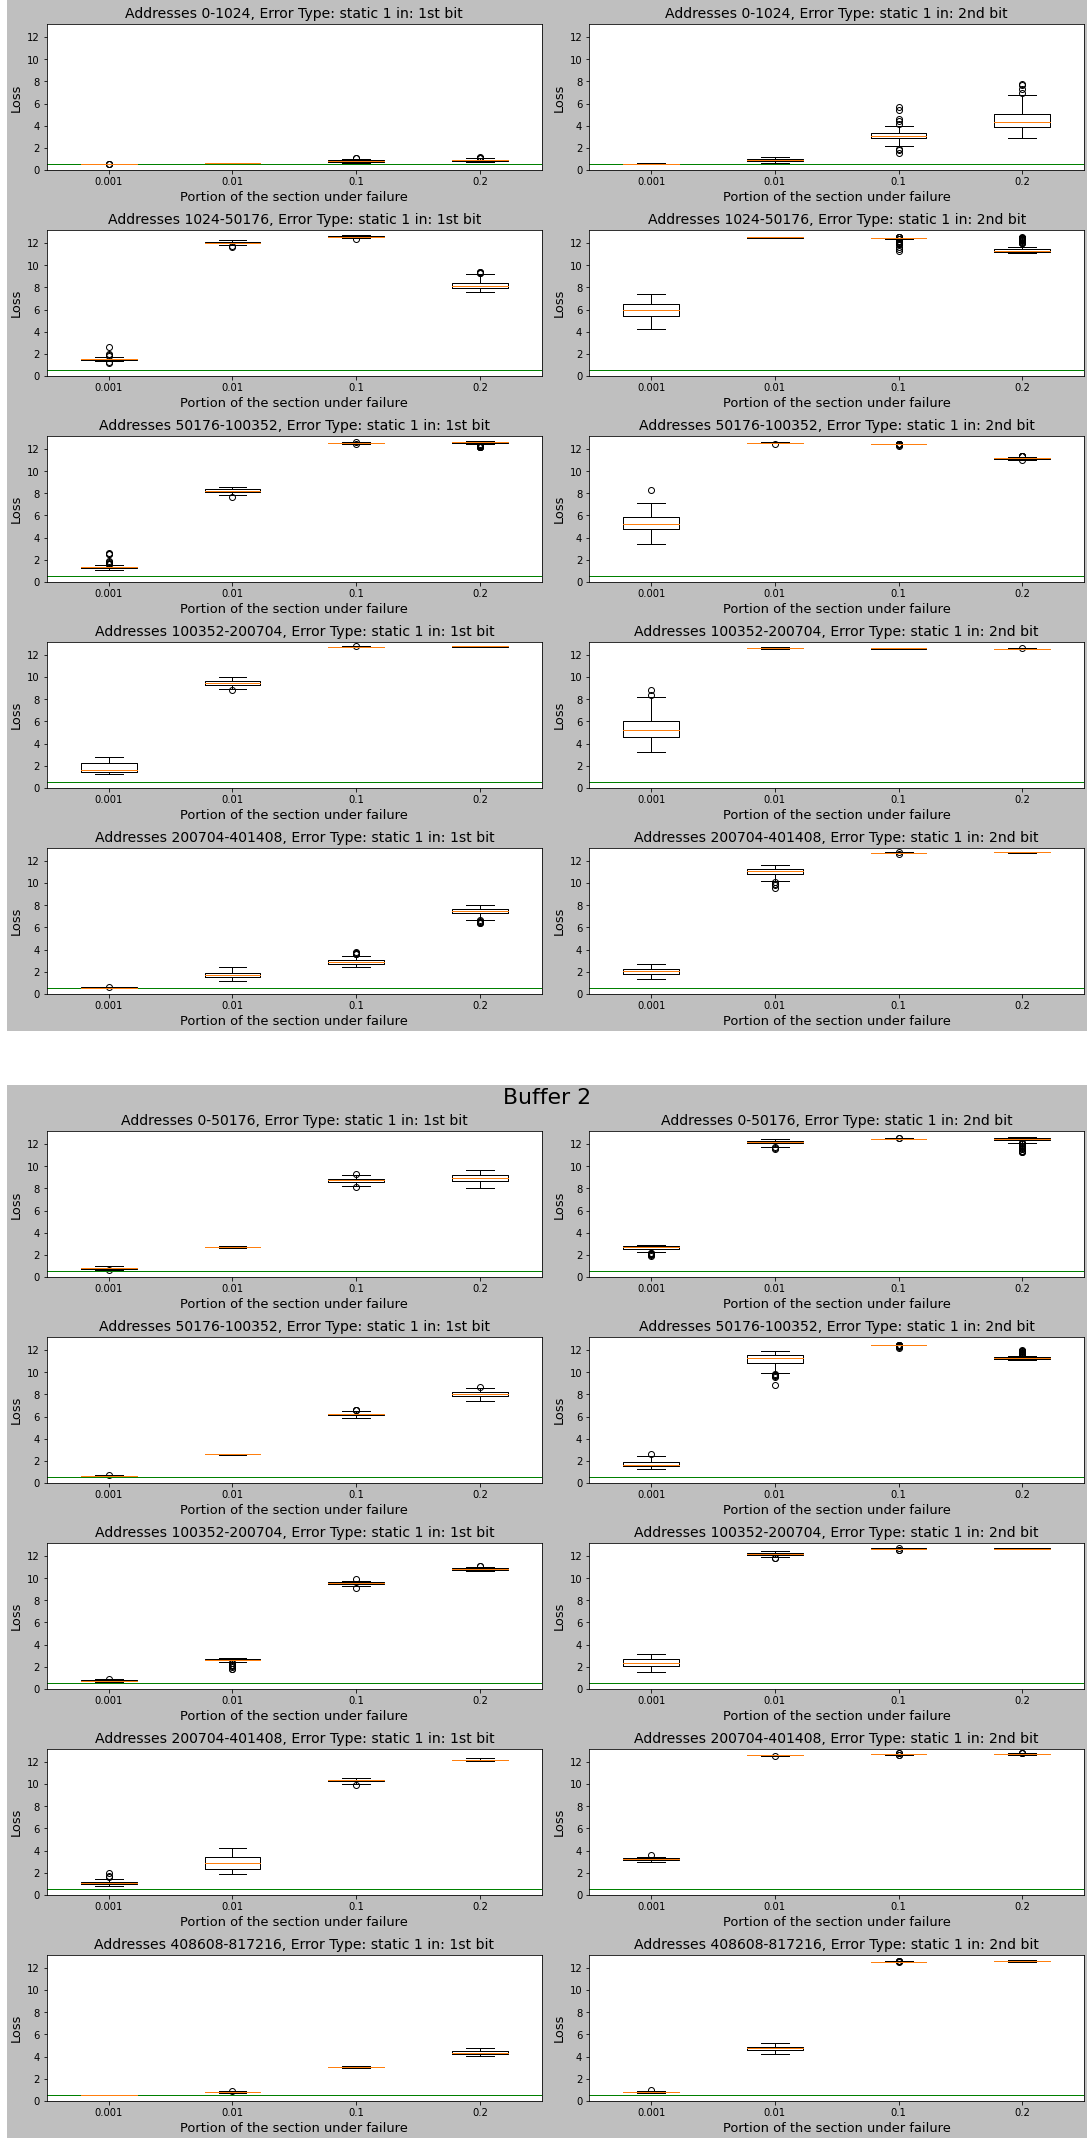

In [46]:
DataDicts = load_obj('Errors/MobileNet/Colorectal Dataset/Weights/Loss')
Sections = [['Addresses 0-1024',  'Addresses 1024-50176', 'Addresses 50176-100352', 'Addresses 100352-200704','Addresses 200704-401408'],
            ['Addresses 0-50176', 'Addresses 50176-100352', 'Addresses 100352-200704','Addresses 200704-401408','Addresses 408608-817216']]
keys1    = ['1st bit','2nd bit']
keys2    = ['Buffer 1','Buffer 2']

Plot_Errors(DataDicts, Sections, keys1, keys2, 0.5168, figsize=(15,30), save_fig=True,
            xlabel  = 'Portion of the section under failure', BoxPlot = True,  Scaled_max_value= 11, ylabel = 'Loss',
            fig_dir = 'Figures/Errors/MobileNet/Colorectal Dataset/Weights/Loss BoxPlot')